# TP classification de sons à rendre

Tom Bevan (tom.bevan@etu.unice.fr)
Vinh Faucher (vinh.faucher@etu.unice.fr)

Polytech SI3 - SSII - 2021-22

# Données

Nous avons choisi 4 mots : gauche, droite, milieu, bas.
Pour chaque mot, nous avons au minimum 31 enregistrements différents.
Nous avons dû faire un prétraitement, afin notamment de convertir les fichiers en wav et pour certains de les découper.

In [20]:
#les imports nécessaires pour la suite
import matplotlib.pyplot as plt
import numpy as np 
import librosa
import librosa.display
import IPython.display as ipd
import glob
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.cluster import KMeans

In [21]:
import sklearn
print(sklearn.__version__)

1.0.2


## Les données
On va utiliser le jeu de données <a href="https://ai.googleblog.com/2017/08/launching-speech-commands-dataset.html">"speech commands"</a>.

In [22]:
basedir="./Sons/"
# à adapter selon l'ordinateur
classes = ["Gauche", "Droite", "Milieu", "Bas"] #Nos classes

In [23]:
for cl in classes:
    listSons = glob.glob(basedir+cl+"/*.wav")
    print(len(listSons), "sons de la classe ", cl)

33 sons de la classe  Gauche
35 sons de la classe  Droite
31 sons de la classe  Milieu
33 sons de la classe  Bas


### On commence avec un seul son (au choix)
Charger le son

In [24]:
y, sr = librosa.load(listSons[0])

### Calcul des MFCCs du son

In [25]:
mfccFeatures = librosa.feature.mfcc(y,sr,n_mfcc=13)

In [26]:
mfccFeatures.shape

(13, 61)

## Calcul des MFCCs de tous les sons

### On va partir d'une base de 24 sons de chaque classe

In [27]:
nb=24
nbMFCCtotal = 0

for cl in classes:
    listSons = glob.glob(basedir+ cl+"/*.wav")
    for s in listSons[:nb]:
        print("###",s,"###")
        (sig,rate) = librosa.load(s)
        mfcc_feat = librosa.feature.mfcc(sig,rate,n_mfcc=13)
        print("MFCC: ", mfcc_feat.shape, "longueur du son : ", len(sig))
        nbMFCCtotal += mfcc_feat.shape[1]


### ./Sons/Gauche\AM_gauche.wav ###
MFCC:  (13, 69) longueur du son :  35280
### ./Sons/Gauche\AP_Gauche.wav ###
MFCC:  (13, 74) longueur du son :  37632
### ./Sons/Gauche\A_Gauche.wav ###
MFCC:  (13, 65) longueur du son :  32928
### ./Sons/Gauche\Gauche1.wav ###
MFCC:  (13, 108) longueur du son :  55125
### ./Sons/Gauche\Gauche10.wav ###
MFCC:  (13, 68) longueur du son :  34304
### ./Sons/Gauche\Gauche11.wav ###
MFCC:  (13, 164) longueur du son :  83456
### ./Sons/Gauche\Gauche12.wav ###
MFCC:  (13, 44) longueur du son :  22050
### ./Sons/Gauche\Gauche13.wav ###
MFCC:  (13, 35) longueur du son :  17640
### ./Sons/Gauche\Gauche14.wav ###
MFCC:  (13, 44) longueur du son :  22051
### ./Sons/Gauche\Gauche15.wav ###
MFCC:  (13, 35) longueur du son :  17643
### ./Sons/Gauche\Gauche16.wav ###
MFCC:  (13, 44) longueur du son :  22053
### ./Sons/Gauche\Gauche17.wav ###
MFCC:  (13, 83) longueur du son :  41984
### ./Sons/Gauche\Gauche18.wav ###
MFCC:  (13, 64) longueur du son :  32256
### ./Son

In [28]:
lesMfcc = np.empty(shape=(nb*len(classes), 13), dtype=float) 
verbose=True

i=0
for cl in classes:
    listSons = glob.glob(basedir+cl+"/*.wav")
    for s in listSons[:nb]:
        if verbose:
            print("###",s,"###")
        (sig,rate) = librosa.load(s)
        mfcc_feat = librosa.feature.mfcc(sig,rate,n_mfcc=13)
        if verbose:
            print("MFCC: ", mfcc_feat.shape, "len : ", len(sig))
        lesMfcc[i] = np.mean(mfcc_feat, axis=1)
        i += 1

if verbose:
    print("shape : ",lesMfcc.shape)


### ./Sons/Gauche\AM_gauche.wav ###
MFCC:  (13, 69) len :  35280
### ./Sons/Gauche\AP_Gauche.wav ###
MFCC:  (13, 74) len :  37632
### ./Sons/Gauche\A_Gauche.wav ###
MFCC:  (13, 65) len :  32928
### ./Sons/Gauche\Gauche1.wav ###
MFCC:  (13, 108) len :  55125
### ./Sons/Gauche\Gauche10.wav ###
MFCC:  (13, 68) len :  34304
### ./Sons/Gauche\Gauche11.wav ###
MFCC:  (13, 164) len :  83456
### ./Sons/Gauche\Gauche12.wav ###
MFCC:  (13, 44) len :  22050
### ./Sons/Gauche\Gauche13.wav ###
MFCC:  (13, 35) len :  17640
### ./Sons/Gauche\Gauche14.wav ###
MFCC:  (13, 44) len :  22051
### ./Sons/Gauche\Gauche15.wav ###
MFCC:  (13, 35) len :  17643
### ./Sons/Gauche\Gauche16.wav ###
MFCC:  (13, 44) len :  22053
### ./Sons/Gauche\Gauche17.wav ###
MFCC:  (13, 83) len :  41984
### ./Sons/Gauche\Gauche18.wav ###
MFCC:  (13, 64) len :  32256
### ./Sons/Gauche\Gauche19.wav ###
MFCC:  (13, 64) len :  32256
### ./Sons/Gauche\Gauche2.wav ###
MFCC:  (13, 31) len :  15435
### ./Sons/Gauche\Gauche20.wav ###
MFC

### Classification linéaire des sons

Il ne reste plus que l'étape de classification des sons. On va utiliser pour cela une méthode simple de classification linéaire: <a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html">la régression logistique</a>.

In [29]:
# création de l'objet de regression logistique
logisticRegr = LogisticRegression()

# classes des sons:
yTrain = []
for clNumber in range(len(classes)):
    yTrain += [clNumber]*nb

# apprentissage de la séparation en utilisation des données pour lesquelles on connait la classe
logisticRegr.fit(lesMfcc, yTrain)


C:\Users\Vinh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [30]:
scaler = preprocessing.StandardScaler().fit(lesMfcc)

print(scaler.mean_)
print(scaler.scale_)

xTrain = scaler.transform(lesMfcc)

[-4.78574109e+02  8.48325775e+01  1.50443787e+01  1.83302242e+01
  2.55594794e+00  6.14859614e+00 -2.17643263e+00 -2.54853707e-01
 -4.22506791e+00  4.49146098e-01 -2.89862999e+00 -3.47633045e-01
 -3.74531842e+00]
[78.45399078 27.05161594 11.70750327 12.4709003  10.52341361  7.79785018
  7.31325653  7.10183625  5.94089722  4.9692214   6.38911479  4.84522938
  4.26318789]


In [31]:
ypred = logisticRegr.predict(xTrain)
print("train F1 score = ", f1_score(yTrain, ypred, average = 'micro'))
print("train accuracy score = ", accuracy_score(yTrain, ypred))


train F1 score =  0.71875
train accuracy score =  0.71875


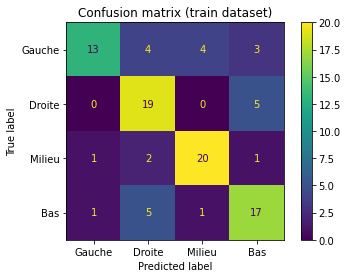

In [32]:
cm = confusion_matrix(yTrain, ypred, labels=[0,1,2,3])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()
disp.ax_.set_title('Confusion matrix (train dataset)')
plt.show()

### Evaluation de la classification

Pour évaluer de façon juste, on va utiliser des sons qui n'ont pas déjà servi à l'apprentissage. On va par exemple prendre les nb derniers de chaque classe.

In [33]:
nb = 6
lesMfccTest = np.empty(shape=(nb*len(classes), 13), dtype=float)
verbose=True

i=0
for cl in classes:
    listSons = glob.glob(basedir+ cl+"/*.wav")
    for s in listSons[-nb:]:
        if verbose:
            print("###",s,"###")
        (sig,rate) = librosa.load(s)
        mfcc_feat = librosa.feature.mfcc(sig,rate,n_mfcc=13)
        if verbose:
            print("MFCC: ", mfcc_feat.shape, "len : ", len(sig))
        lesMfccTest[i] = np.mean(mfcc_feat, axis=1)
        i += 1

if verbose:
    print("shape : ",lesMfccTest.shape)
    
xTest = scaler.transform(lesMfccTest)
yTest = []
for clNumber in range(len(classes)):
    yTest += [clNumber]*nb

### ./Sons/Gauche\Gauche5.wav ###
MFCC:  (13, 44) len :  22050
### ./Sons/Gauche\Gauche6.wav ###
MFCC:  (13, 65) len :  33075
### ./Sons/Gauche\Gauche7.wav ###
MFCC:  (13, 103) len :  52479
### ./Sons/Gauche\Gauche8.wav ###
MFCC:  (13, 82) len :  41472
### ./Sons/Gauche\Gauche9.wav ###
MFCC:  (13, 82) len :  41472
### ./Sons/Gauche\V_Gauche.wav ###
MFCC:  (13, 122) len :  62093
### ./Sons/Droite\Droite5.wav ###
MFCC:  (13, 44) len :  22050
### ./Sons/Droite\Droite6.wav ###
MFCC:  (13, 44) len :  22050
### ./Sons/Droite\Droite7.wav ###
MFCC:  (13, 91) len :  46305
### ./Sons/Droite\Droite8.wav ###
MFCC:  (13, 57) len :  28672
### ./Sons/Droite\Droite9.wav ###
MFCC:  (13, 116) len :  58880
### ./Sons/Droite\V_Droite.wav ###
MFCC:  (13, 108) len :  55037
### ./Sons/Milieu\Milieu5.wav ###
MFCC:  (13, 23) len :  11764
### ./Sons/Milieu\Milieu6.wav ###
MFCC:  (13, 36) len :  18379
### ./Sons/Milieu\Milieu7.wav ###
MFCC:  (13, 84) len :  42777
### ./Sons/Milieu\Milieu8.wav ###
MFCC:  (13, 94)

In [34]:
predTest = logisticRegr.predict(xTest)
print("test F1 score = ", f1_score(yTest, predTest, average = 'micro'))
print("test accuracy score = ", accuracy_score(yTest, predTest))


test F1 score =  0.4166666666666667
test accuracy score =  0.4166666666666667


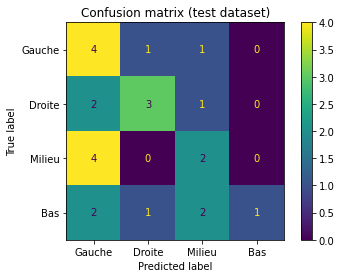

In [35]:
cm = confusion_matrix(yTest, predTest, labels=[0,1,2,3])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()
disp.ax_.set_title('Confusion matrix (test dataset)')
plt.show()

# Classification par sac de descripteurs

In [42]:
lesMfcc = lesMfcc.transpose()
k=5
kmeans1 = KMeans(n_clusters=k, init='k-means++', n_init=10)
kmeans1.fit([lesMfcc])

ValueError: Found array with dim 3. Estimator expected <= 2.